<a href="https://colab.research.google.com/github/akumarpandey686/DataPreprocessing_Code/blob/master/vgg16_feature_extraction_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16

In [12]:
# Re-size all the images to this
img_width, img_height = 224, 224  # Default input size for VGG16

train_dir = '/content/drive/My Drive/Data/train'
valid_dir = '/content/drive/My Drive/Data/test'

In [13]:
# Instantiate convolutional base

conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))

# Show architecture
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
# Extract features
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

In [31]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 5

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count,2))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='categorical')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, 173)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(valid_dir, 18)
#test_features, test_labels = extract_features(test_dir, test_size)

Found 173 images belonging to 2 classes.
Found 18 images belonging to 2 classes.


In [32]:
train_labels
print(len(train_labels))

173


In [33]:
epochs = 150

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=(7,7,512)))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 1,026
Trainable params: 1,026
Non-trainable params: 0
_________________________________________________________________


In [34]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

# Compile model
from keras.optimizers import Adam
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['acc'])

# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    callbacks=[checkpoint],
                    validation_data=(validation_features, validation_labels))

Epoch 1/150
18/35 [==============>...............] - ETA: 0s - loss: 0.7036 - acc: 0.5111
Epoch 00001: val_loss improved from inf to 0.67882, saving model to model-001-0.618497-0.500000.h5
35/35 [==============================] - 0s 8ms/step - loss: 0.6226 - acc: 0.6185 - val_loss: 0.6788 - val_acc: 0.5000
Epoch 2/150
35/35 [==============================] - ETA: 0s - loss: 0.5136 - acc: 0.7572
Epoch 00002: val_loss improved from 0.67882 to 0.47718, saving model to model-002-0.757225-0.833333.h5
35/35 [==============================] - 0s 4ms/step - loss: 0.5136 - acc: 0.7572 - val_loss: 0.4772 - val_acc: 0.8333
Epoch 3/150
35/35 [==============================] - ETA: 0s - loss: 0.4389 - acc: 0.8497
Epoch 00003: val_loss improved from 0.47718 to 0.42858, saving model to model-003-0.849711-0.833333.h5
35/35 [==============================] - 0s 4ms/step - loss: 0.4389 - acc: 0.8497 - val_loss: 0.4286 - val_acc: 0.8333
Epoch 4/150
33/35 [===========================>..] - ETA: 0s - loss:

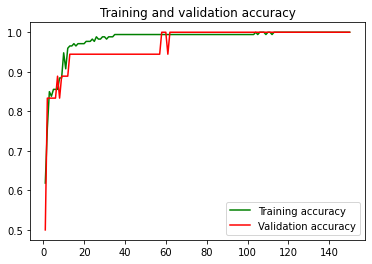

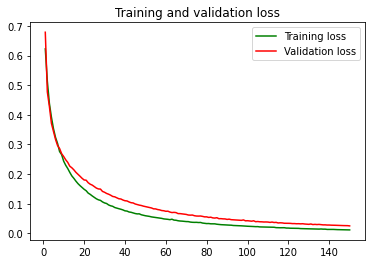

In [35]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [37]:
from keras.preprocessing import image
def prediction(img_path):
    org_img = image.load_img(img_path)
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(org_img)                           
    plt.axis('off')
    plt.show()


    # Extract features
    features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

    # Make prediction
    try:
        prediction = model.predict(features)
    except:
        prediction = model.predict(features.reshape(1, 7*7*512))
        
    classes = ["np", "p"]
    print("I see..."+str(classes[np.argmax(np.array(prediction[0]))]))

In [41]:
#refer https://www.youtube.com/watch?v=PaSEVY9d4RI&t=1272s